In [1]:
from datetime import date
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [5]:
%matplotlib widget

In [6]:
save_dir = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim\pictures and plots")

In [7]:
data_dir = Path(r"P:\\")
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim\subject_metadata.csv")
all_subexp = pd.read_csv(subject_csv)
all_subexp.head()

,mouse,sex,DOB,strain,exp_folder,histology,EEG,stim_tip_distance,tiparea,dist_CL,color
0,mouse771424,F,NaN,C57BL/6J,THstim_d1_2024-11-14_11-28-16,True,False,300,TH,0.925338,tomato
1,mouse771424,F,NaN,C57BL/6J,THstim_d2_2024-11-15_10-51-49,True,False,300,CP,1.494992,firebrick
2,mouse771425,F,NaN,C57BL/6J,THstim_d1_2024-11-21_10-59-24,True,False,300,PAL,1.286954,limegreen
3,mouse771425,F,NaN,C57BL/6J,THstim_d2_2024-11-22_10-49-58,True,False,300,int,1.435270,forestgreen
4,mouse771426,M,NaN,C57BL/6J,THstim_d1_2024-12-19_12-19-39,True,False,100,AV,0.686477,violet


# Load single experiment

In [8]:
choose_sub = 7
exprow = all_subexp.iloc[choose_sub]
data_path = os.path.join(data_dir, exprow.mouse, exprow.exp_folder, 'experiment1', 'recording1')
exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


In [9]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\THstim_project', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

THstim_d2


Get coords for stim electrode

In [10]:
stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
if os.path.exists(stim_elec_file):
    with open(stim_elec_file) as elec_file:
        stim_elec_data = json.load(elec_file)
else:
    print('Stim electrode location file not found.')

In [11]:
stim_elec_data

{'surface': {'area': 'RSPd1', 'ccf_coords': [270, 12, 204]},
 'tip': {'area': 'CL', 'ccf_coords': [263, 131, 198]}}

## Load other data

### Load stim log and simple log

In [12]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
else:
    print('No stim log found.')

In [13]:
simple_log_file = exp.stimulus_log_file[:exp.stimulus_log_file.find('estim_log')] + 'simple_' + exp.stimulus_log_file[exp.stimulus_log_file.find('estim_log'):]
if os.path.exists(simple_log_file):
    simple_log = pd.read_csv(simple_log_file)
elif os.path.exists(os.path.join(exp.data_folder, r'simple_estim_log.csv')):
    simple_log = pd.read_csv(os.path.join(exp.data_folder, r'simple_estim_log.csv'))
else:
    print('No simple log found')

In [14]:
simple_log.head()

,stim_type,parameter,duration,onset,offset,sweep
0,freq50Hz,10,20,1377.05180,1397.05193,0
1,freq50Hz,50,20,1488.10577,1508.10590,0
2,freq50Hz,50,40,1608.41940,1648.41965,0
3,freq50Hz,50,40,1748.36228,1788.36253,0
4,freq50Hz,100,40,1878.41344,1918.41369,0


### Load isoflurane signal

In [15]:
# iso_level, isots = exp.load_analog_iso()
iso_induction, iso_maintenance = exp.load_iso_times()
# iso_level = iso_level - np.mean(iso_level[isots < iso_induction[0]-5])

### Load pupil diameter, if it exists

In [16]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
  
    pupilts = pupildf.sync_time.values
    pupilR = pupildf.Largest_Radius.values
    ## smooth pupil diameter, then normalize ##
    sm_pupil = np.zeros_like(pupilR)
    k = 5 # filter window is actually k*2+1
    for i in range(k, len(pupilR)-k-1):
        sm_pupil[i] = np.mean(pupilR[i-k:i+k]) # each point is the average of k surrounding points
    sm_pupil[:k] = pupilR[:k]
    sm_pupil[-k-1:] = pupilR[-k-1:]
    pupil = sm_pupil / np.mean(pupildf.Eye_Diameter.values)
    print('{:d}% of frames do not have good pupil measurements'.format(int((np.sum(np.isnan(pupilR)) / len(pupilR)) * 100)))
else:
    print('No local Pupileye*.csv file. Check server.')

0% of frames do not have good pupil measurements


In [17]:
np.mean(pupildf.Eye_Diameter.values)

351.24527970968785

In [18]:
awake_pupil_mean = np.nanmean(sm_pupil[pupilts < iso_induction[0]])
awake_pupil_std = np.nanstd(sm_pupil[pupilts < iso_induction[0]])
pupilsr = 30 # smaple rate, 30 Hz

### Load running

## Plot the events

Original plot

Plot for BSS

## Get event related pupil signals

In [19]:
simple_log.head()

,stim_type,parameter,duration,onset,offset,sweep
0,freq50Hz,10,20,1377.05180,1397.05193,0
1,freq50Hz,50,20,1488.10577,1508.10590,0
2,freq50Hz,50,40,1608.41940,1648.41965,0
3,freq50Hz,50,40,1748.36228,1788.36253,0
4,freq50Hz,100,40,1878.41344,1918.41369,0


In [20]:
evind = 2
eventrow = simple_log.iloc[evind]
print(eventrow)

stim_type      freq50Hz
parameter            50
duration             40
onset         1608.4194
offset       1648.41965
sweep                 0
Name: 2, dtype: object


In [34]:
preinds = np.nonzero((pupilts > eventrow.onset - eventrow.duration) & (pupilts < eventrow.onset))[0]
pre_mean = np.nanmean(sm_pupil[preinds])
stiminds = np.nonzero((pupilts >= eventrow.onset) & (pupilts <= eventrow.offset))[0]
stim_mean = np.nanmean(sm_pupil[stiminds])
postinds = np.nonzero((pupilts > eventrow.offset) & (pupilts < eventrow.offset + eventrow.duration))[0]
post_mean = np.nanmean(sm_pupil[postinds])

In [35]:
print(awake_pupil_mean)
print(pre_mean)
print(stim_mean)
print(post_mean)
stim_change = (stim_mean - pre_mean) / pre_mean
print(stim_change)

28.46614817236348
17.697240328119314
25.601439571747076
18.991292185067536
0.4466345654507898


(-1.0, 100.0)

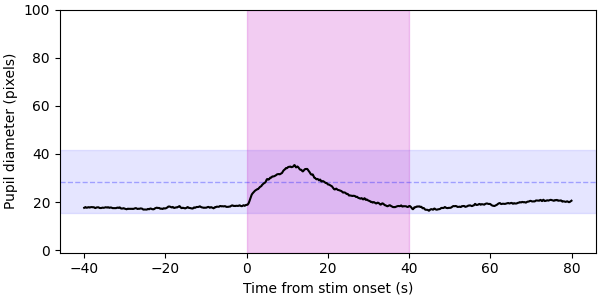

In [36]:
fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)
timewin = [eventrow.onset - eventrow.duration, eventrow.offset + eventrow.duration]
einds = np.nonzero((pupilts >= timewin[0]) & (pupilts <= timewin[1]))
timex = pupilts[einds] - eventrow.onset
ax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color='b', alpha=0.1)
ax.axhline(awake_pupil_mean, color='b', linewidth=1.0, linestyle='dashed', alpha=0.3)
ax.plot(timex, sm_pupil[einds], color='k')
ax.axvspan(0, eventrow.duration, color='m', alpha=0.2)
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Pupil diameter (pixels)')
ax.set_ylim([-1, 100])

All events

In [21]:
baseline_pmean = np.zeros((len(simple_log)), dtype=float)
stim_pmean = np.zeros((len(simple_log)), dtype=float)
post_pmean = np.zeros((len(simple_log)), dtype=float)
barlabels = []
for ei, eventrow in simple_log.iterrows():
    ## Get pupil trace ##
    tempinds = np.nonzero((pupilts > eventrow.onset - eventrow.duration) & (pupilts < eventrow.onset))[0]
    ## Get pre, stim, post mean diameter ##
    baseline_pmean[ei] = np.nanmean(sm_pupil[tempinds])
    tempinds = np.nonzero((pupilts >= eventrow.onset) & (pupilts <= eventrow.offset))[0]
    stim_pmean[ei] = np.nanmean(sm_pupil[tempinds])
    tempinds = np.nonzero((pupilts > eventrow.offset) & (pupilts < eventrow.offset + eventrow.duration))[0]
    post_pmean[ei] = np.nanmean(sm_pupil[tempinds])
    barlabels.append('ST{:d}\n{}\n{:d}$\mu$A'.format(ei, eventrow.stim_type[4:], eventrow.parameter))
pupil_perchange = (stim_pmean - baseline_pmean) / baseline_pmean

Bar plot of percent change

Text(0, 0.5, '% change\n(relative to baseline)')

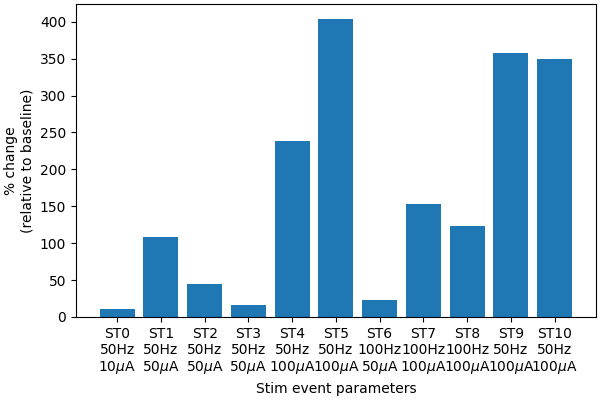

In [22]:
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.bar(barlabels, pupil_perchange * 100)
ax.set_xlabel('Stim event parameters')
ax.set_ylabel('% change\n(relative to baseline)')

Loop through all 40 s events to get avg pupil trace

In [23]:
pdur = 40
stim40s = simple_log[simple_log['duration'] == pdur].reset_index()
stim40s

,index,stim_type,parameter,duration,onset,offset,sweep
0,2,freq50Hz,50,40,1608.41940,1648.41965,0
1,3,freq50Hz,50,40,1748.36228,1788.36253,0
2,4,freq50Hz,100,40,1878.41344,1918.41369,0
3,5,freq50Hz,100,40,2118.02391,2158.02416,0
4,6,freq100Hz,50,40,2389.13647,2429.13671,0
5,7,freq100Hz,100,40,2518.52211,2558.52236,0
6,8,freq100Hz,100,40,2728.72235,2768.72259,0
7,9,freq50Hz,100,40,2984.99033,3024.99057,0
8,10,freq50Hz,100,40,3227.98436,3267.98458,0


In [25]:
timewin = [-40., 60.]
samples = int((pdur + np.abs(timewin[0]) + np.abs(timewin[1])) * pupilsr)
timex = np.linspace(timewin[0], pdur + timewin[1], samples)
eventpupil = np.zeros((samples, len(stim40s)), dtype=float)
for ei, eventrow in stim40s.iterrows():
    ## Get pupil trace ##
    startind = np.nonzero(pupilts >= eventrow.onset + timewin[0])[0][0]
    eventpupil[:, ei] = sm_pupil[startind:startind + samples]

    # einds = np.nonzero((pupilts >= timewin[0]) & (pupilts <= timewin[1]))
    # timex = pupilts[einds] - eventrow.onset

(-1.0, 100.0)

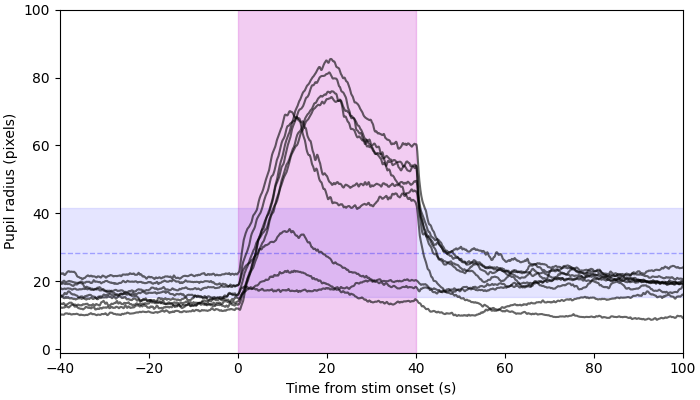

In [27]:
fig, ax = plt.subplots(figsize=(7,4), constrained_layout=True)
ax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color='b', alpha=0.1)
ax.axhline(awake_pupil_mean, color='b', linewidth=1.0, linestyle='dashed', alpha=0.3)
ax.plot(timex, eventpupil, color='k', alpha=0.6)
ax.axvspan(0, eventrow.duration, color='m', alpha=0.2)
ax.set_xlabel('Time from stim onset (s)')
ax.set_xlim([timewin[0], pdur + timewin[1]])
ax.set_ylabel('Pupil radius (pixels)')
ax.set_ylim([-1, 100])

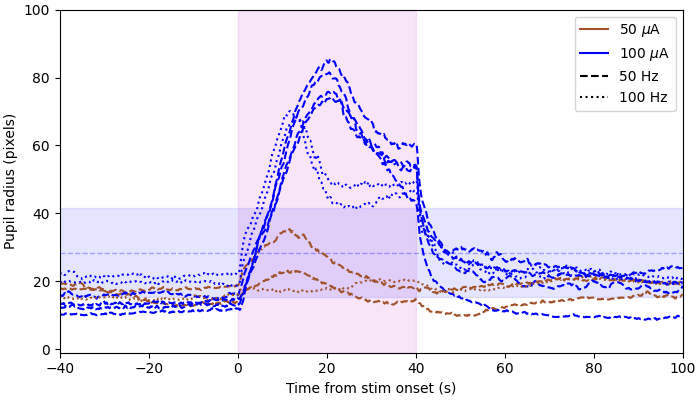

In [28]:
fig, ax = plt.subplots(figsize=(7,4), constrained_layout=True)
ax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color='b', alpha=0.1)
ax.axhline(awake_pupil_mean, color='b', linewidth=1.0, linestyle='dashed', alpha=0.3)
ax.axvspan(0, eventrow.duration, color='m', alpha=0.1)
for ei, eventrow in stim40s.iterrows():
    if '100' in eventrow.stim_type:
        ls = 'dotted'
    elif '50' in eventrow.stim_type:
        ls = 'dashed'

    if eventrow.parameter == 100:
        lc = 'blue'
    elif eventrow.parameter == 50:
        lc = 'sienna'
        
    ax.plot(timex, eventpupil[:, ei], color=lc, linestyle=ls)
ax.set_xlabel('Time from stim onset (s)')
ax.set_xlim([timewin[0], pdur + timewin[1]])
ax.set_ylabel('Pupil radius (pixels)')
ax.set_ylim([-1, 100])

## Create the legend ##
customleg = [
    Line2D([0], [0], color='sienna'),
    Line2D([0], [0], color='blue'),
    Line2D([0], [0], color='k', linestyle='dashed'),
    Line2D([0], [0], color='k', linestyle='dotted'),
]
ax.legend(customleg, ['50 $\mu$A', '100 $\mu$A', '50 Hz', '100 Hz'])

## Save figure ##
fig_name = '{}_pupil_eventtraces_{:d}sevents_final.png'.format(exp_tag, pdur)
fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

# Load all subjects to loop through

In [29]:
all_subexp.head()

,mouse,sex,DOB,strain,exp_folder,histology,EEG,stim_tip_distance,tiparea,dist_CL,color
0,mouse771424,F,NaN,C57BL/6J,THstim_d1_2024-11-14_11-28-16,True,False,300,TH,0.925338,tomato
1,mouse771424,F,NaN,C57BL/6J,THstim_d2_2024-11-15_10-51-49,True,False,300,CP,1.494992,firebrick
2,mouse771425,F,NaN,C57BL/6J,THstim_d1_2024-11-21_10-59-24,True,False,300,PAL,1.286954,limegreen
3,mouse771425,F,NaN,C57BL/6J,THstim_d2_2024-11-22_10-49-58,True,False,300,int,1.435270,forestgreen
4,mouse771426,M,NaN,C57BL/6J,THstim_d1_2024-12-19_12-19-39,True,False,100,AV,0.686477,violet


Loop through each subject to make the plot

mouse771424: THstim_d1
Experiment type: electrical stimulation
 44% of frames do not have good pupil measurements. Not analyzing.

mouse771424: THstim_d2
Experiment type: electrical stimulation
 52% of frames do not have good pupil measurements. Not analyzing.

mouse771425: THstim_d1
Experiment type: electrical stimulation

mouse771425: THstim_d2
Experiment type: electrical stimulation

mouse771426: THstim_d1
Experiment type: electrical stimulation

mouse771426: THstim_d2
Experiment type: electrical stimulation

mouse771427: THstim_d1
Experiment type: electrical stimulation

mouse771427: THstim_d2
Experiment type: electrical stimulation

mouse771427: THstim_d3
Experiment type: electrical and sensory stimulation


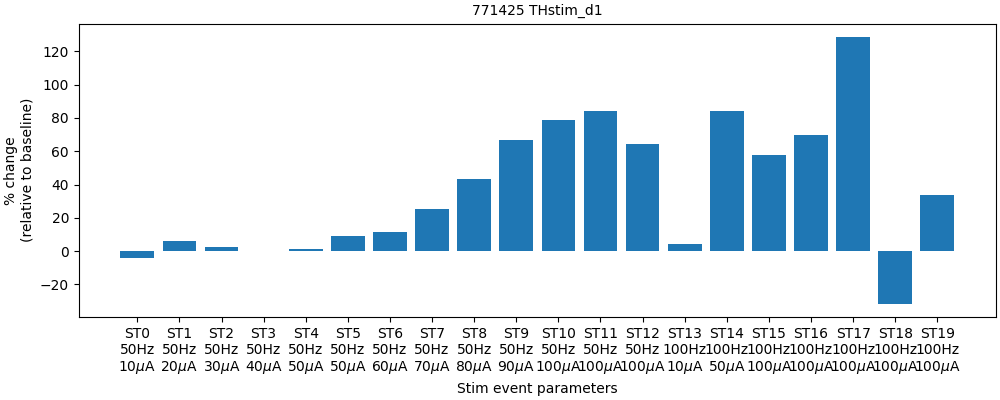

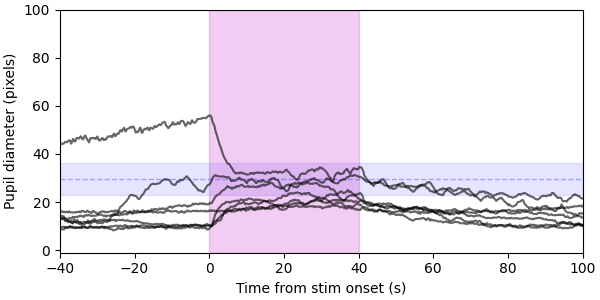

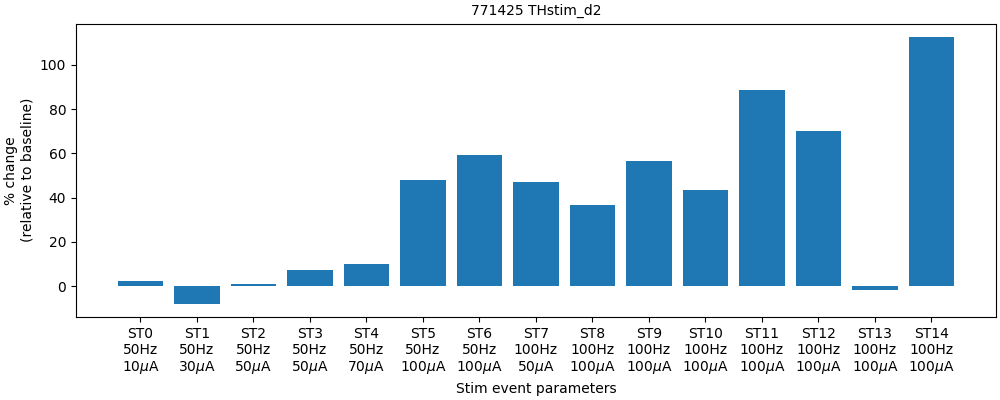

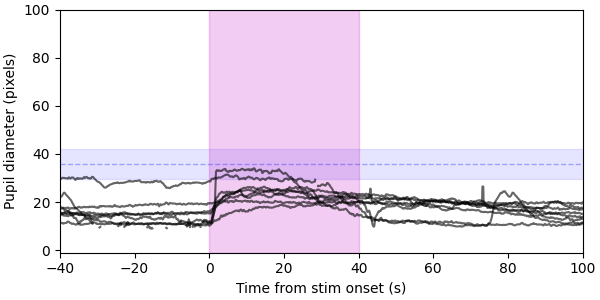

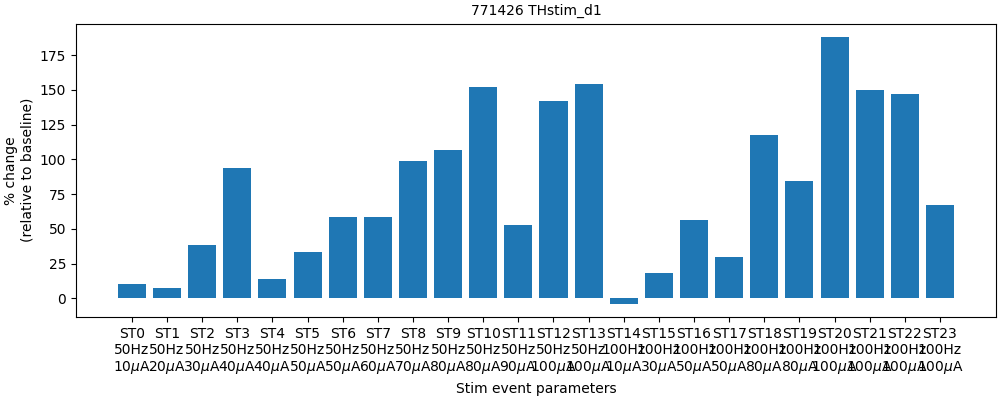

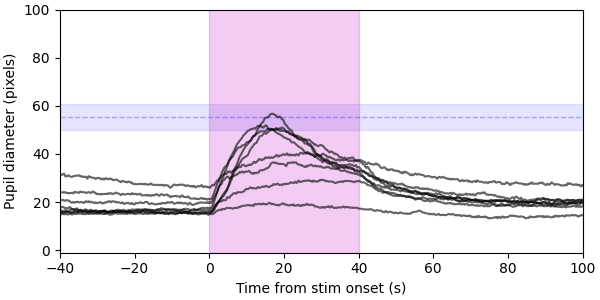

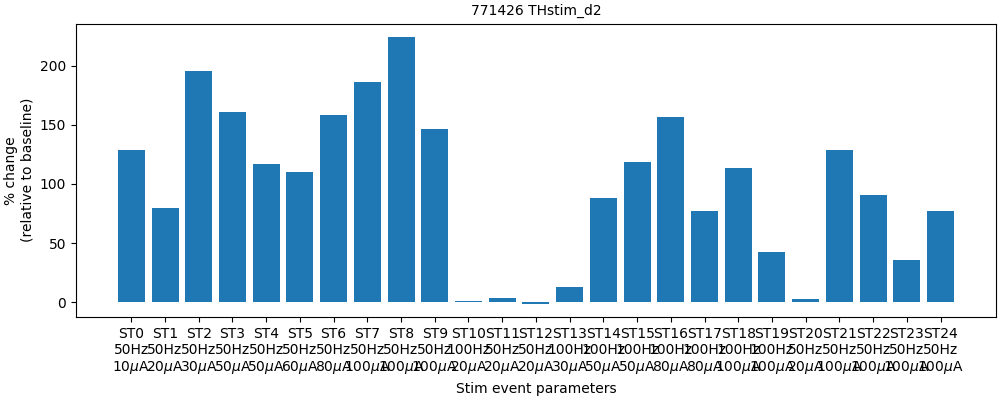

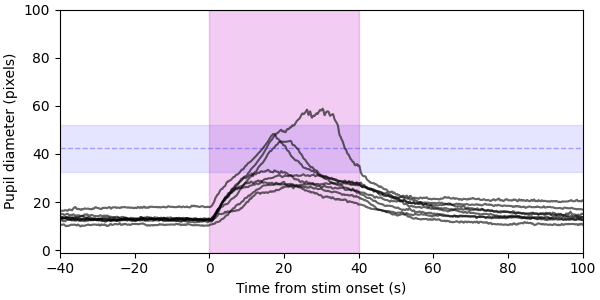

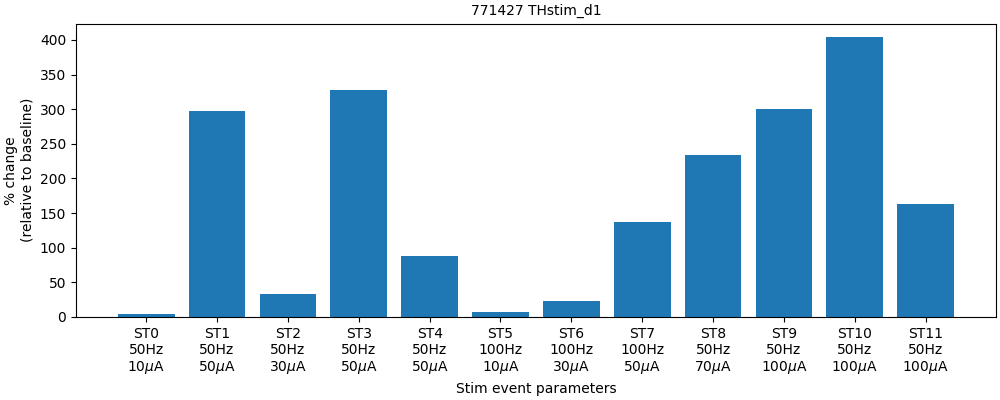

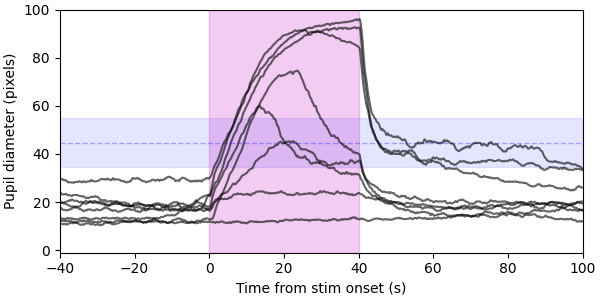

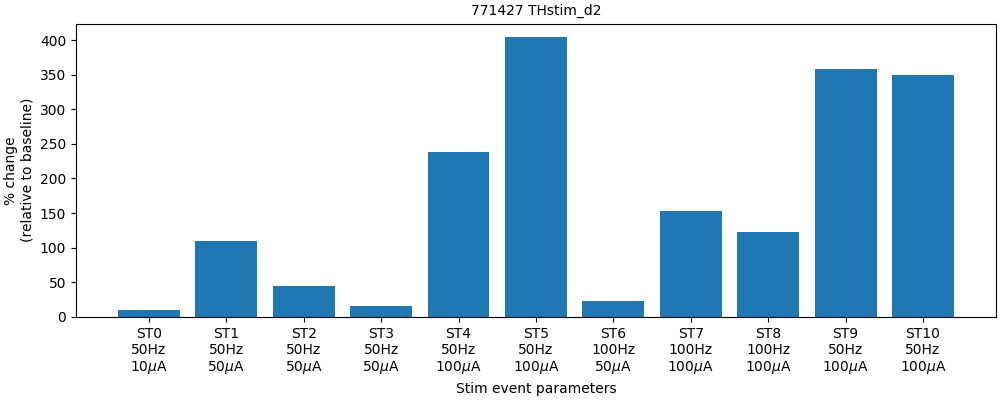

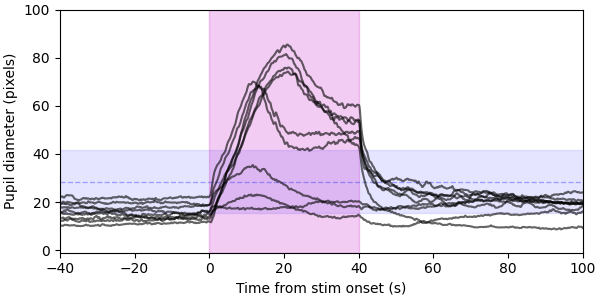

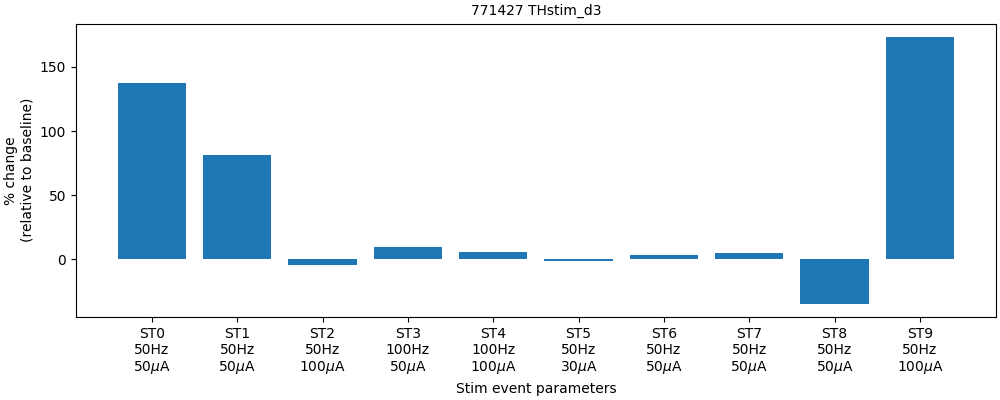

In [31]:
pdur = 40
pupilsr = 30
timewin = [-40., 60.]
samples = int((pdur + np.abs(timewin[0]) + np.abs(timewin[1])) * pupilsr)
timex = np.linspace(timewin[0], pdur + timewin[1], samples)
mean_perch_allevents = []
for indi, exprow in all_subexp.iterrows():
    exp_tag = exprow.exp_folder[:9]
    print('{}: {}'.format(exprow.mouse, exp_tag))
    
    data_path = os.path.join(data_dir, exprow.mouse, exprow.exp_folder, 'experiment1', 'recording1')
    exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)
    plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\THstim_project', 'mouse' + exp.mouse)
    if not os.path.exists(plotsavedir):
        os.mkdir(plotsavedir)

    ## Get stim elec location ##
    stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
    if os.path.exists(stim_elec_file):
        with open(stim_elec_file) as elec_file:
            stim_elec_data = json.load(elec_file)
    else:
        print(' No stim electrode .json file.\n')
        continue

    ## Load the simple log ##
    simple_log_file = exp.stimulus_log_file[:exp.stimulus_log_file.find('estim_log')] + 'simple_' + exp.stimulus_log_file[exp.stimulus_log_file.find('estim_log'):]
    if os.path.exists(simple_log_file):
        simple_log = pd.read_csv(simple_log_file)
    elif os.path.exists(os.path.join(exp.data_folder, r'simple_estim_log.csv')):
        simple_log = pd.read_csv(os.path.join(exp.data_folder, r'simple_estim_log.csv'))
    else:
        print(' No simple stim log found.\n')
        continue

    ## Load the iso times ##
    iso_induction, iso_maintenance = exp.load_iso_times()
    
    ## Load the pupil file ##
    if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
        pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
        pupildf = pd.read_csv(pupil_file)
        pupilts = pupildf.sync_time.values
        pupilD = pupildf.Largest_Radius.values
        pupilnanfraction = np.sum(np.isnan(pupilD)) / len(pupilD)
        if pupilnanfraction > 0.2:
            print(' {:d}% of frames do not have good pupil measurements. Not analyzing.\n'.format(int((pupilnanfraction) * 100)))
            continue
        ## smooth pupil diameter, then normalize ##
        sm_pupil = np.zeros_like(pupilD)
        k = 5 # filter window is actually k*2+1
        for i in range(k, len(pupilD)-k-1):
            sm_pupil[i] = np.mean(pupilD[i-k:i+k]) # each point is the average of k surrounding points
        sm_pupil[:k] = pupilD[:k]
        sm_pupil[-k-1:] = pupilD[-k-1:]
        awake_pupil_mean = np.nanmean(sm_pupil[pupilts < iso_induction[0]])
        awake_pupil_std = np.nanstd(sm_pupil[pupilts < iso_induction[0]])
    else:
        print(' No local Pupileye*.csv file. Check server.\n')
        continue

    ## Load the running signal ##
    # running_file = os.path.join(exp.data_folder, 'running_signal.npy')
    # running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')
    # if os.path.exists(running_file) and os.path.exists(running_ts_file):
    #     speed = np.load(running_file)
    #     speedts = np.load(running_ts_file)

    ## Loop through all events ##
    baseline_pmean = np.zeros((len(simple_log)), dtype=float)
    stim_pmean = np.zeros((len(simple_log)), dtype=float)
    post_pmean = np.zeros((len(simple_log)), dtype=float)
    barlabels = []
    for ei, eventrow in simple_log.iterrows():
        tempinds = np.nonzero((pupilts > eventrow.onset - eventrow.duration) & (pupilts < eventrow.onset))[0]
        baseline_pmean[ei] = np.nanmean(sm_pupil[tempinds])
        tempinds = np.nonzero((pupilts >= eventrow.onset) & (pupilts <= eventrow.offset))[0]
        stim_pmean[ei] = np.nanmean(sm_pupil[tempinds])
        tempinds = np.nonzero((pupilts > eventrow.offset) & (pupilts < eventrow.offset + eventrow.duration))[0]
        post_pmean[ei] = np.nanmean(sm_pupil[tempinds])
        barlabels.append('ST{:d}\n{}\n{:d}$\mu$A'.format(ei, eventrow.stim_type[4:], eventrow.parameter))
    pupil_perchange = (stim_pmean - baseline_pmean) / baseline_pmean
    mean_perch_allevents.append(pupil_perchange)

    ## Create the bar plot ##
    figbar, bax = plt.subplots(figsize=(10,4), constrained_layout=True)
    bax.bar(barlabels, pupil_perchange * 100)
    bax.set_xlabel('Stim event parameters')
    bax.set_ylabel('% change\n(relative to baseline)')
    bax.set_title('{} {}'.format(exp.mouse, exp_tag))
    # barfig_name = '{}_eventpupil_perchbar_allevents.png'.format(exp_tag)
    # figbar.savefig(os.path.join(plotsavedir, barfig_name), transparent=False)

    ## Make the evoked pupil traces plot ##
    stim40s = simple_log[simple_log['duration'] == pdur].reset_index()
    if len(stim40s) == 0:
        continue
    eventpupil = np.zeros((samples, len(stim40s)), dtype=float)
    for ei, eventrow in stim40s.iterrows():
        ## Get pupil trace ##
        startind = np.nonzero(pupilts >= eventrow.onset + timewin[0])[0][0]
        eventpupil[:, ei] = sm_pupil[startind:startind + samples]

    figpt, ptax = plt.subplots(figsize=(6,3), constrained_layout=True)
    ptax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color='b', alpha=0.1)
    ptax.axhline(awake_pupil_mean, color='b', linewidth=1.0, linestyle='dashed', alpha=0.3)
    ptax.plot(timex, eventpupil, color='k', alpha=0.6)
    ptax.axvspan(0, eventrow.duration, color='m', alpha=0.2)
    ptax.set_xlabel('Time from stim onset (s)')
    ptax.set_xlim([timewin[0], pdur + timewin[1]])
    ptax.set_ylabel('Pupil diameter (pixels)')
    ptax.set_ylim([-1, 100])
    # fig_name = '{}_pupil_eventtraces_{:d}sevents.png'.format(exp_tag, pdur)
    # figpt.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

    print('')

Plot pupil change compared to CL dist

In [32]:
subs = all_subexp[2:]
subs.head()

,mouse,sex,DOB,strain,exp_folder,histology,EEG,stim_tip_distance,tiparea,dist_CL,color
2,mouse771425,F,NaN,C57BL/6J,THstim_d1_2024-11-21_10-59-24,True,False,300,PAL,1.286954,limegreen
3,mouse771425,F,NaN,C57BL/6J,THstim_d2_2024-11-22_10-49-58,True,False,300,int,1.435270,forestgreen
4,mouse771426,M,NaN,C57BL/6J,THstim_d1_2024-12-19_12-19-39,True,False,100,AV,0.686477,violet
5,mouse771426,M,NaN,C57BL/6J,THstim_d2_2024-12-20_09-28-35,True,False,100,AV,0.940744,darkviolet
6,mouse771427,M,NaN,C57BL/6J,THstim_d1_2025-01-22_10-36-51,True,True,100,DG-po,0.868188,cyan


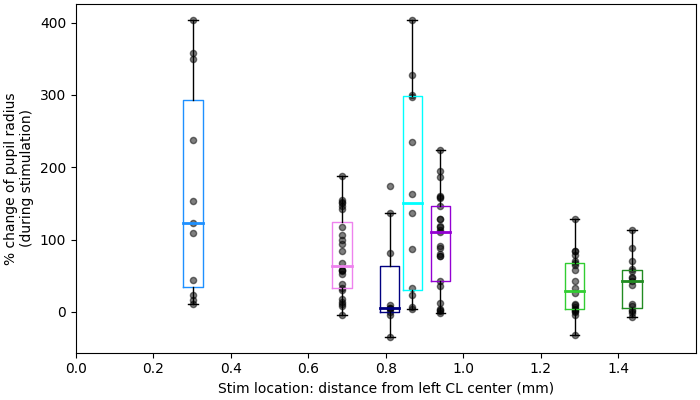

In [33]:
fig, ax = plt.subplots(figsize=(7, 4), constrained_layout=True)
xlims = [0, 1.6]
for (ii, rowi), perchi in zip(subs.iterrows(), mean_perch_allevents):
    # xs = np.random.normal(indi, 0.1, len(yvals))
    xs = [rowi.dist_CL] * len(perchi)
    ax.boxplot(
        perchi * 100, positions=[rowi.dist_CL], widths=[0.05], showfliers=False,
        medianprops={'color': rowi.color, 'linewidth': 2}, boxprops={'color': rowi.color}
        )
    ax.scatter(xs, perchi * 100, c='k', marker='o', s=20, alpha=0.5)

ax.set_xlim(xlims)
ax.set_xticks(np.arange(xlims[0], xlims[1], 0.2))
ax.set_xticklabels(np.arange(xlims[0], xlims[1], 0.2).round(decimals=1))
ax.set_xlabel('Stim location: distance from left CL center (mm)')
ax.set_ylabel('% change of pupil radius\n(during stimulation)')

fig_name = 'allsessions_stimpupilchange_{}.png'.format(date.today().strftime('%b%d%Y'))
fig.savefig(os.path.join(save_dir, fig_name), transparent=False)